In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding, LSTM, GRU, Dense, Dropout, Bidirectional, Input
)
from tensorflow.keras.regularizers import l2


2026-02-14 12:38:08.126319: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771072688.322366      17 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771072688.380681      17 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771072688.835094      17 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771072688.835157      17 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771072688.835161      17 computation_placer.cc:177] computation placer alr

In [2]:

df = pd.read_csv(
    '/kaggle/input/rotten-tomatoes-movies-and-critic-reviews-dataset/rotten_tomatoes_critic_reviews.csv'
).dropna(subset=['review_content', 'review_type'])

In [3]:
df.head()

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
0,m/0814255,Andrew L. Urban,False,Urban Cinefile,Fresh,NaN,2010-02-06,A fantasy adventure that fuses Greek mythology...
1,m/0814255,Louise Keller,False,Urban Cinefile,Fresh,NaN,2010-02-06,"Uma Thurman as Medusa, the gorgon with a coiff..."
2,m/0814255,NaN,False,FILMINK (Australia),Fresh,NaN,2010-02-09,With a top-notch cast and dazzling special eff...
3,m/0814255,Ben McEachen,False,Sunday Mail (Australia),Fresh,3.5/5,2010-02-09,Whether audiences will get behind The Lightnin...
4,m/0814255,Ethan Alter,True,Hollywood Reporter,Rotten,NaN,2010-02-10,What's really lacking in The Lightning Thief i...


In [4]:
df = df.sample(20000, random_state=42)

# Fresh = 1, Rotten = 0
df['label'] = df['review_type'].apply(lambda x: 1 if x == 'Fresh' else 0)

# Аналіз довжини текстів
df['word_count'] = df['review_content'].apply(lambda x: len(str(x).split()))

print("Розподіл класів:")
print(df['label'].value_counts(normalize=True))


Розподіл класів:
label
1    0.6396
0    0.3604
Name: proportion, dtype: float64


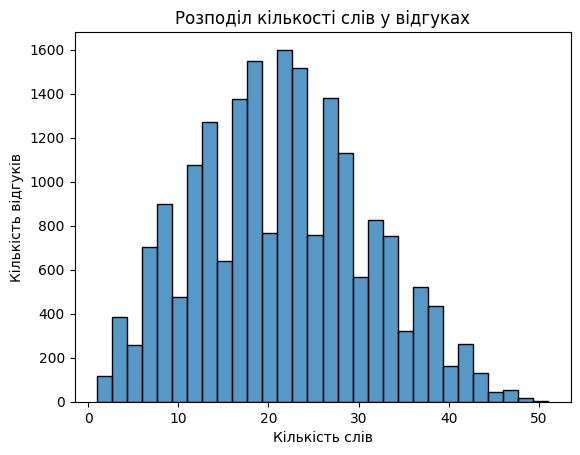

In [5]:
sns.histplot(df['word_count'], bins=30)
plt.title("Розподіл кількості слів у відгуках")
plt.xlabel("Кількість слів")
plt.ylabel("Кількість відгуків")
plt.show()

In [6]:

from collections import Counter

all_words = " ".join(df['review_content']).lower().split()
most_common_words = Counter(all_words).most_common(20)

print("Найчастіші слова:")
for word, freq in most_common_words:
    print(f"{word}: {freq}")

Найчастіші слова:
the: 22010
a: 15304
and: 13281
of: 12801
to: 9004
is: 7706
in: 6145
that: 4900
it: 4574
as: 3863
with: 3615
but: 3612
for: 3160
this: 3138
its: 2704
it's: 2676
an: 2593
film: 2350
on: 1987
be: 1864


In [7]:
max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words, oov_token="<UNK>")
tokenizer.fit_on_texts(df['review_content'])

sequences = tokenizer.texts_to_sequences(df['review_content'])
X = pad_sequences(sequences, maxlen=max_len)
y = df['label'].values

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [9]:
def build_model(rnn_type='LSTM'):
    model = Sequential()
    model.add(Input(shape=(max_len,)))
    model.add(Embedding(max_words, 128))
    
    if rnn_type == 'LSTM':
        model.add(Bidirectional(LSTM(64, kernel_regularizer=l2(0.001))))
    elif rnn_type == 'GRU':
        model.add(Bidirectional(GRU(64, kernel_regularizer=l2(0.001))))
    
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [10]:
model = build_model('LSTM')
model.summary()

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)

2026-02-14 12:38:32.576892: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,378,945 (5.26 MB)

 Trainable params: 1,378,945 (5.26 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 28s 110ms/step - accuracy: 0.6324 - loss: 0.7878 - val_accuracy: 0.7125 - val_loss: 0.5570
Epoch 2/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 25s 109ms/step - accuracy: 0.8013 - loss: 0.4557 - val_accuracy: 0.7437 - val_loss: 0.5342
Epoch 3/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 25s 111ms/step - accuracy: 0.8762 - loss: 0.3234 - val_accuracy: 0.7425 - val_loss: 0.5597
Epoch 4/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 24s 107ms/step - accuracy: 0.9147 - loss: 0.2376 - val_accuracy: 0.7450 - val_loss: 0.6796
Epoch 5/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 25s 110ms/step - accuracy: 0.9443 - loss: 0.1732 - val_accuracy: 0.7412 - val_loss: 0.7026
Epoch 6/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 24s 108ms/step - accuracy: 0.9613 - loss: 0.1309 - val_accuracy: 0.7450 - val_loss: 0.9414
Epoch 7/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 24s 107ms/step - accuracy: 0.9725 - loss: 0.0955 - val_accuracy: 0.7350 - val_loss: 1.0222
Epoch 8/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 24s 109ms/step - accuracy: 0.9817 - loss: 0

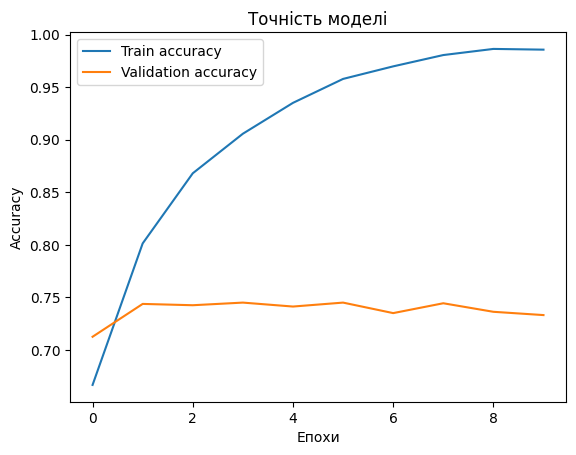

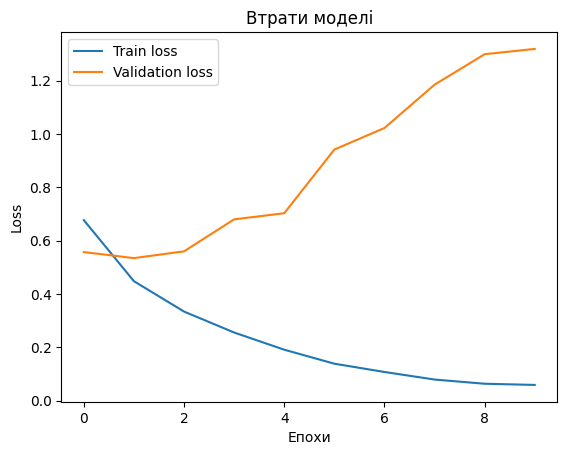

In [11]:
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Точність моделі')
plt.xlabel('Епохи')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
# Loss
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Втрати моделі')
plt.xlabel('Епохи')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [12]:
y_pred = (model.predict(X_test) > 0.5).astype(int)

print(classification_report(y_test, y_pred))

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-score: {f1:.3f}")

125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step
              precision    recall  f1-score   support

           0       0.64      0.60      0.62      1442
           1       0.78      0.81      0.80      2558

    accuracy                           0.73      4000
   macro avg       0.71      0.70      0.71      4000
weighted avg       0.73      0.73      0.73      4000

Precision: 0.781
Recall: 0.812
F1-score: 0.796


In [13]:
for rnn in ['LSTM', 'GRU']:
    print(f"\nНавчання моделі: {rnn}")
    model = build_model(rnn)
    model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.1)


Навчання моделі: LSTM
Epoch 1/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 27s 108ms/step - accuracy: 0.6345 - loss: 0.8000 - val_accuracy: 0.6594 - val_loss: 0.6062
Epoch 2/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 24s 107ms/step - accuracy: 0.7564 - loss: 0.5232 - val_accuracy: 0.7387 - val_loss: 0.5394
Epoch 3/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 24s 107ms/step - accuracy: 0.8578 - loss: 0.3603 - val_accuracy: 0.7513 - val_loss: 0.5482
Epoch 4/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 24s 106ms/step - accuracy: 0.9117 - loss: 0.2567 - val_accuracy: 0.7456 - val_loss: 0.6013
Epoch 5/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 24s 107ms/step - accuracy: 0.9435 - loss: 0.1791 - val_accuracy: 0.7387 - val_loss: 0.7054

Навчання моделі: GRU
Epoch 1/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 28s 109ms/step - accuracy: 0.6445 - loss: 0.7894 - val_accuracy: 0.7231 - val_loss: 0.5524
Epoch 2/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 24s 107ms/step - accuracy: 0.7766 - loss: 0.4901 - val_accuracy: 0.7431 - val_loss: 0.5216
Epoch 3/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 24s 10